<a href="https://colab.research.google.com/github/pchlenski/gda_project/blob/main/experiments/PCA_and_independence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab imports
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Environmental variables
DD = '/content/drive/My Drive/notebooks/4995/data/' # data dir

import matplotlib.pyplot as plt

import networkx
from sklearn.preprocessing import LabelEncoder

!pip install causalnex
from causalnex.structure.notears import from_pandas

from sklearn.decomposition import PCA


Mounted at /content/drive
     |████████████████████████████████| 154 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 1.9 MB 52.0 MB/s 
     |████████████████████████████████| 22.3 MB 85.7 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=63eedf0896dfc46297e7d384b92995cf347f573d5c57159008ec8d1ac01ac944
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.0
    Uninstalling wrapt-1.14.0:
      Successfully uninstalled wrapt-1.14.0
ERROR: pip's dependency resolver does not currently take into account

# n --> n dimensional PCA

## Ground-truth model

Following instructions in https://causalnex.readthedocs.io/en/latest/03_tutorial/01_first_tutorial.html

In [2]:
# Data

data = pd.read_csv(f"{DD}student-por.csv", delimiter=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
# Convert to numeric

le = LabelEncoder()

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)
for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,0,14,14,14
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,0,11,13,13


In [4]:
sm = from_pandas(data)

In [9]:
sm.__dict__.keys()

dict_keys(['graph_attr_dict_factory', 'node_dict_factory', 'node_attr_dict_factory', 'adjlist_outer_dict_factory', 'adjlist_inner_dict_factory', 'edge_attr_dict_factory', 'graph', '_node', '_adj', '_pred', '_succ'])

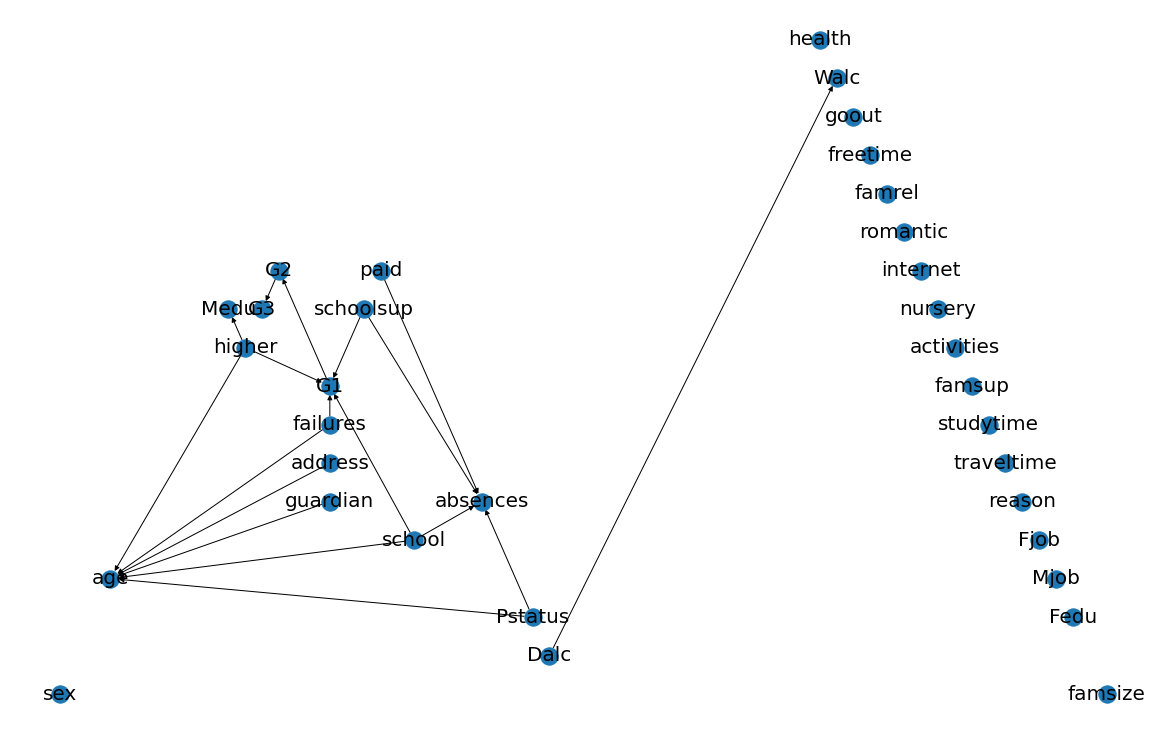

In [36]:
sm.remove_edges_below_threshold(0.8)

plt.figure(figsize=(16,10))
networkx.draw(
    sm, 
    labels={x: x for x in list(sm.__dict__['_node'])},
    pos=networkx.planar_layout(sm),
    font_size=20, 
)

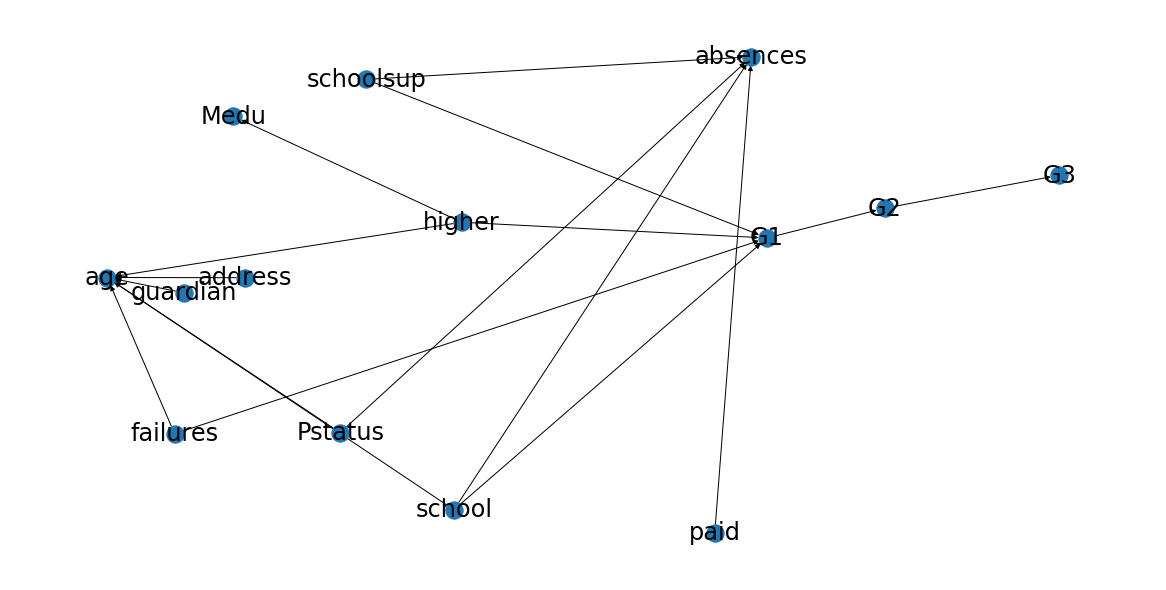

In [12]:
# Let's get a reduced dataset

sm_digraph = networkx.DiGraph(sm)
cc = max(networkx.weakly_connected_components(sm_digraph), key=len)
subgraph = sm_digraph.subgraph(cc)

fig = plt.figure(figsize=(16,8))
networkx.draw(
    subgraph, 
    labels={x: x for x in cc}, 
    font_size=24,
    pos=networkx.spring_layout(subgraph)
)

In [13]:
# Looks good! Now let's prune the dataset

data_reduced = data[cc]

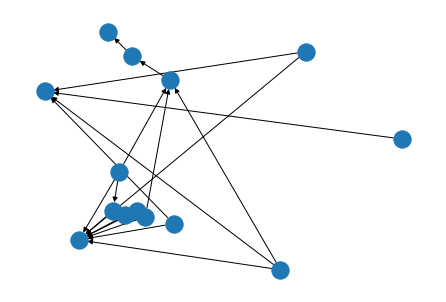

In [14]:
# Finally, let's verify that we learn the same graph:

sm_check = from_pandas(data_reduced)
sm_check.remove_edges_below_threshold(0.8)
networkx.draw(sm_check)



## PCA

In [15]:
# How many dimensions in the original dataset?

data_reduced.shape # Answer is 14

(649, 14)

In [16]:
pca = PCA(n_components = data_reduced.shape[1]) # 14-dimensional PCA

data_pca = pca.fit_transform(data_reduced.values)
data_pca_pd = pd.DataFrame(data_pca, columns=data_reduced.columns)

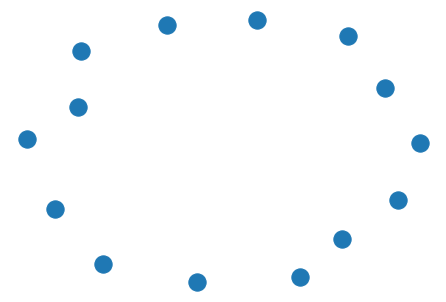

In [17]:
sm2 = from_pandas(data_pca_pd)
# sm2.remove_edges_below_threshold(0.8)
networkx.draw(sm2) # Even without dropping edges, we do NOT get a connected graph

The inverse problem is as follows:

$$
X_{PCA} = XR\\
X^{\dagger}X_{PCA} \approx R\\
X_{PCA}R^{-1} = X\\
R^{-1} = X_{PCA}^\dagger X
$$

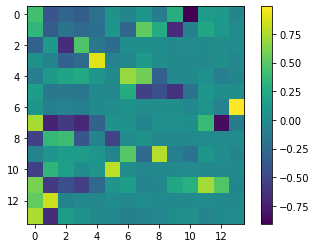

In [18]:
# Solve the inverse problem:

X = data_reduced.values
R = np.linalg.pinv(X) @ data_pca

plt.imshow(R)
plt.colorbar()

In [19]:
# Observation 1: True to being a rotation matrix, L2 norm of each row is very close to 1
np.linalg.norm(R, axis=1)

array([1.23915152, 1.158986  , 0.91933181, 0.9990511 , 1.03654484,
       1.03844177, 1.01442764, 1.69048455, 1.00700774, 1.01462897,
       1.03477636, 1.48101236, 0.9977027 , 1.02891768])

In [20]:
# Observation 2: something interesting is going on in the first 2 dimensions here:
np.linalg.norm(R, axis=0)

array([1.66033604, 1.61629976, 1.21534559, 1.23689897, 1.0485688 ,
       0.99835198, 0.96425506, 0.99847958, 0.99735457, 0.99999482,
       0.99342698, 0.87180916, 0.99129152, 0.99999769])

<BarContainer object of 14 artists>

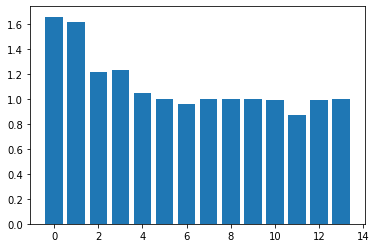

In [21]:
plt.bar(np.arange(14), np.linalg.norm(R, axis=0))

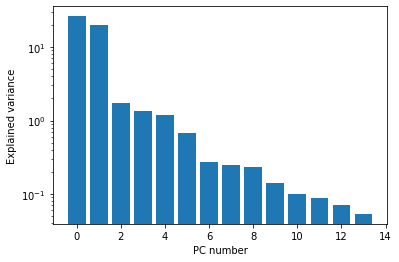

In [22]:
plt.bar(np.arange(14), pca.explained_variance_)
plt.xlabel("PC number")
plt.ylabel("Explained variance")
plt.yscale("log")

12 cells are filled


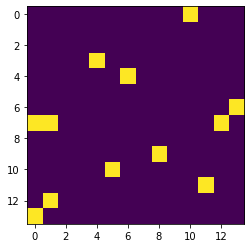

In [23]:
# Pseudo-adjacency matrix from R

R_1 = np.abs(R) > 0.7
plt.imshow(R_1)
print(np.sum(R_1), "cells are filled")

In [24]:
# What contributes a lot to the PCs?
for i in range(14):
    for j in range(14):
        if R_1[i,j]:
            print(f"{data_reduced.columns[i]}\t-->PC{j}")

# Noticing some cycles here, which is problematic

Pstatus	-->PC10
Medu	-->PC4
failures	-->PC6
paid	-->PC13
higher	-->PC0
higher	-->PC1
higher	-->PC12
guardian	-->PC8
G2	-->PC5
schoolsup	-->PC11
absences	-->PC1
age	-->PC0


11 cells are filled


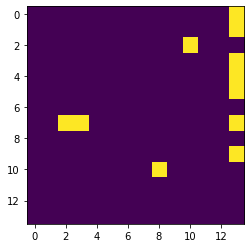

In [25]:
# Real adjacency matrix

R_2 = networkx.to_numpy_matrix(sm_check, nodelist=data_reduced.columns) > 0
plt.imshow(R_2)
print(np.sum(R_2), "cells are filled")

# Not obvious to me how these are related. For one thing, the age node has very high in-degree, whereas in R things are pretty spread out

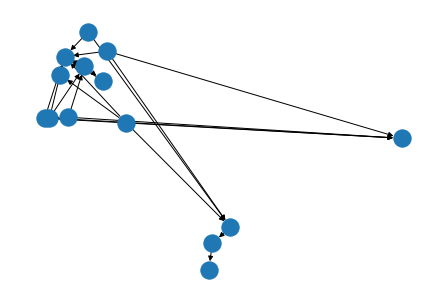

In [26]:
data_reconstructed = data_pca @ np.linalg.inv(R)
pd_reconstructed = pd.DataFrame(data_reconstructed, columns=data_reduced.columns)
sm_reconstructed = from_pandas(pd_reconstructed)
sm_reconstructed.remove_edges_below_threshold(0.8)
networkx.draw(sm_reconstructed) # Seems like (more or less) the same SCM. This is cool

In [27]:
data_reconstructed.shape

(649, 14)

In [28]:
pca2 = PCA(n_components=10)

R_inv_reduced = pca2.fit_transform(np.linalg.inv(R))

sm_10 = from_pandas(pd.DataFrame(data_pca @ R_inv_reduced))
sm_10.remove_edges_below_threshold(0.8)

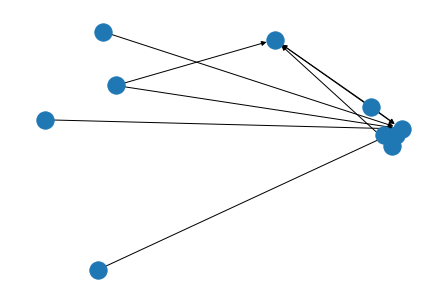

In [29]:
networkx.draw(sm_10, pos=networkx.spring_layout(sm_10))

0


/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")


1


/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/usr/local/lib/python3.7/dist-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")


2
3
4
5
6
7
8
9
10
11
12
13


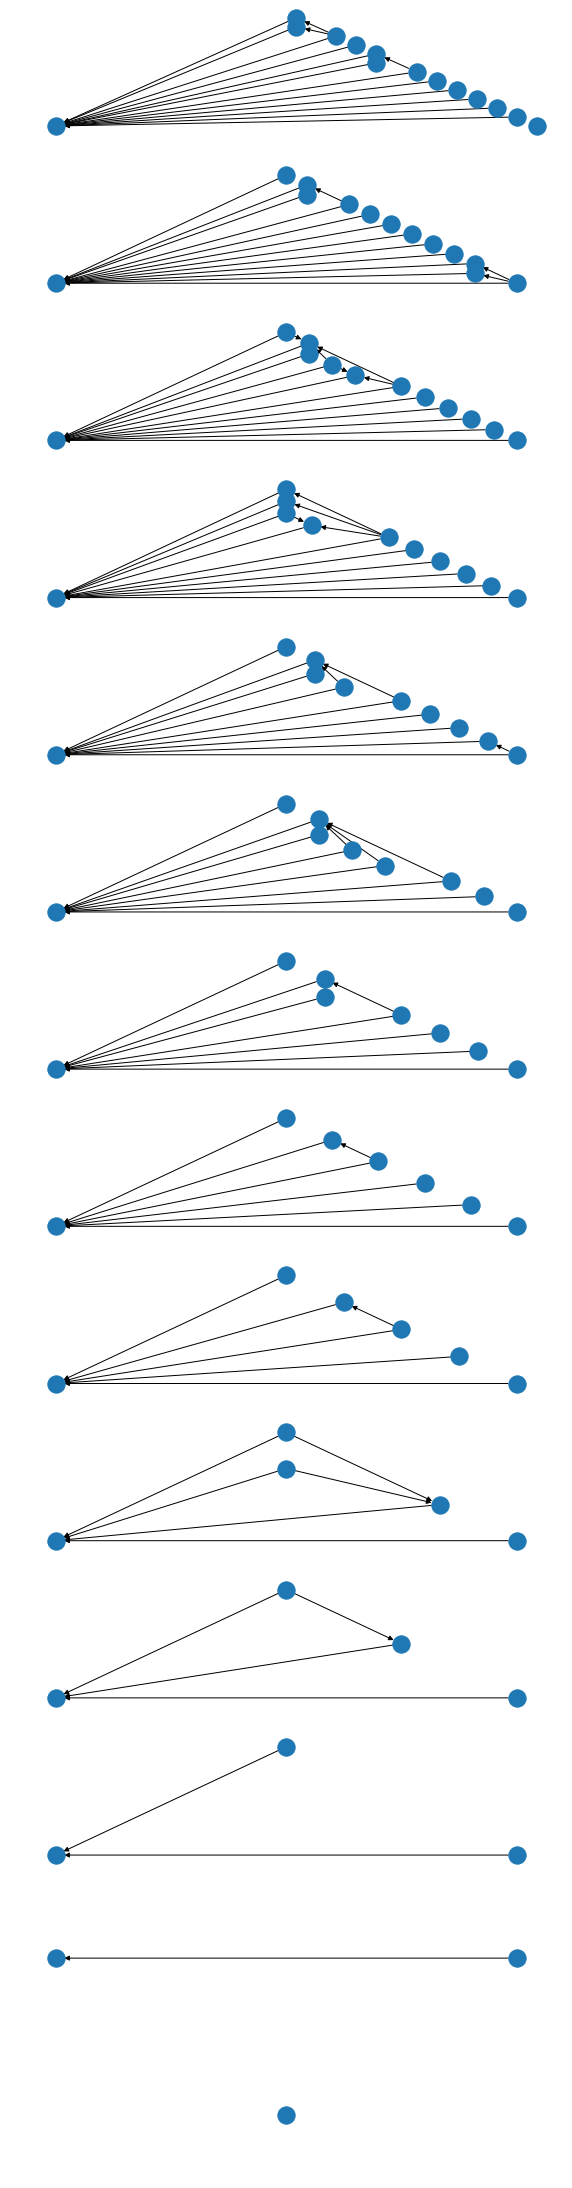

In [30]:
fig, axs = plt.subplots(14,1, figsize=(10,40))

for i in range(14):
    print(i)
    j = 14-i
    pca_i = PCA(n_components=j)
    R_inv_reduced = pca_i.fit_transform(np.linalg.inv(R))
    sm_i = from_pandas(pd.DataFrame(data_pca @ R_inv_reduced))
    sm_i.remove_edges_below_threshold(0.8)
    networkx.draw(sm_i, pos=networkx.planar_layout(sm_i), ax=axs[i])

plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13


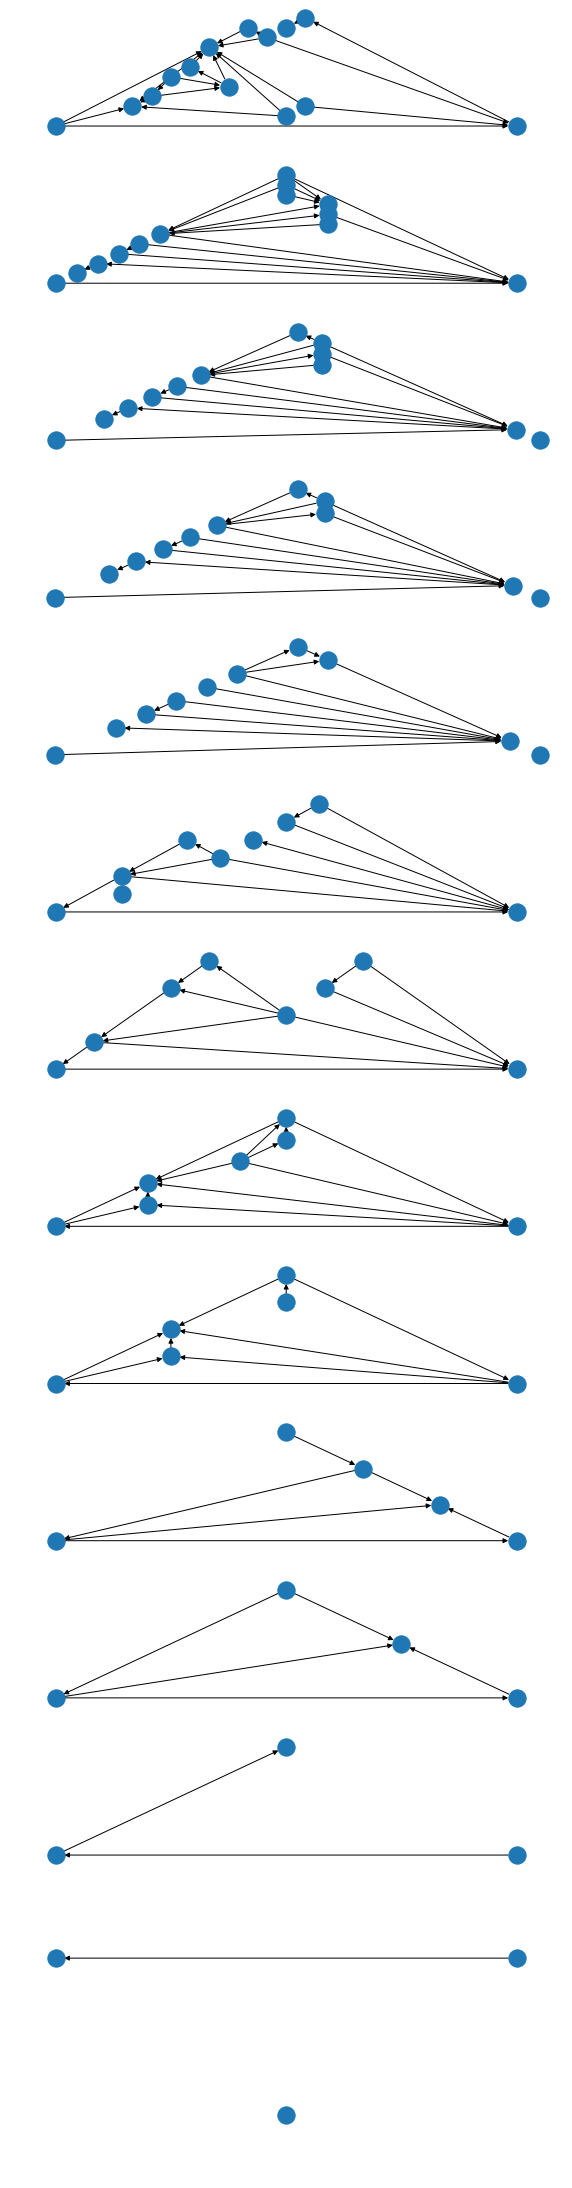

In [31]:
fig, axs = plt.subplots(14,1, figsize=(10,40))

for i in range(14):
    print(i)
    j = 14-i
    # pca_i = PCA(n_components=j)
    # R_inv_reduced = pca_i.fit_transform(np.linalg.inv(R))
    sm_i = from_pandas(pd.DataFrame(data_pca @ np.linalg.inv(R)[:,:j]))
    sm_i.remove_edges_below_threshold(0.8)
    try:
        networkx.draw(sm_i, pos=networkx.planar_layout(sm_i), ax=axs[i])
    except:
        networkx.draw(sm_i, ax=axs[i])

plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13


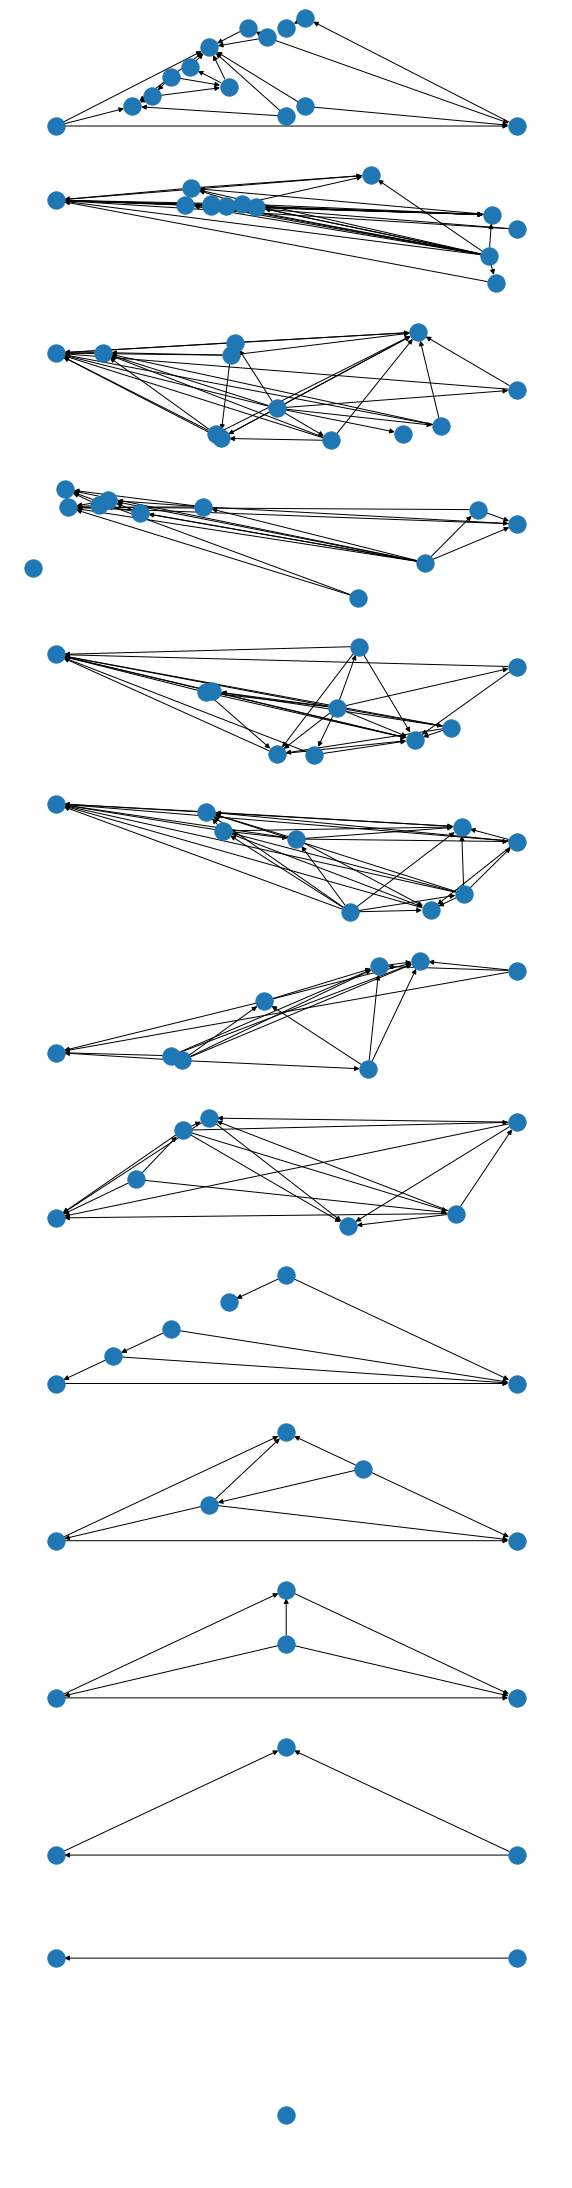

In [44]:
fig, axs = plt.subplots(14,1, figsize=(10,40))

for i in range(14):
    print(i)
    j = 14-i
    # pca_i = PCA(n_components=j)
    # R_inv_reduced = pca_i.fit_transform(np.linalg.inv(R))
    sm_i = from_pandas(pd.DataFrame(data_pca[:,:j] @ np.linalg.inv(R)[:j,:j]))
    sm_i.remove_edges_below_threshold(0.8)
    try:
        networkx.draw(sm_i, pos=networkx.planar_layout(sm_i), ax=axs[i])
    except:
        networkx.draw(sm_i, ax=axs[i])

plt.show()